In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm # progress apply :)
tqdm.pandas()

from datetime import datetime
today=datetime.today().strftime('%Y-%m-%d')

%load_ext autoreload
%autoreload 2
def d(l):
    pd.set_option('display.max_colwidth', l)




In [8]:
#!pip install keybert

In [3]:
# ensure that lists are read as list and not as strings
from ast import literal_eval
columns_to_convert=["texts","labels","retraction_counts","has_retraction","has_retraction_label"]
converters = {col: literal_eval for col in columns_to_convert}


#df=pd.read_csv("2025-04-02b PDF_import (docling - complete).csv",index_col=0, converters=converters)
#df["text"]=df["text"].apply(lambda x: " ".join(x))

df=pd.read_json("2025-04-03 PDF Import complete.json")
df.dropna(subset="texts",inplace=True)

In [5]:
df.loc["Nature293"]

path                    Data_Nature\Not relevant\Not relevant (additio...
folder                  Data_Nature\Not relevant\Not relevant (additio...
journal                                                            Nature
texts                   [INFOCUS, NEWS, China introduces sweeping refo...
labels                  [page_header, page_header, section_header, tex...
retraction_counts       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
has_retraction                                                        1.0
retract_tokens                                                 [re pract]
has_retraction_label                                               [text]
Name: Nature293, dtype: object

In [7]:
from MyLib import labelfilter

# Apply the functions to create new columns
filtered_texts = df.apply(lambda row: labelfilter.filter_texts(row['texts'], row['retraction_counts']), axis=1)
neighboring_texts = df.apply(lambda row: labelfilter.get_neighboring_texts(row['texts'], row['retraction_counts']), axis=1)
texts_until_section_header = df.apply(lambda row: labelfilter.get_texts_until_section_header(row['texts'], row['labels'], row['retraction_counts']), axis=1)

for i in [df.texts, filtered_texts,neighboring_texts,texts_until_section_header]:
    print(i.str.len().mean())

55.03306366514246
1.737952866690116
6.58353851565248
3.442842068237777


In [9]:
df["text"]=neighboring_texts.apply(lambda x: " ".join(x))

In [11]:
import pandas as pd
import spacy

#!python -m spacy download en_core_web_trf
#import spacy_transformers
#from spacytextblob.spacytextblob import SpacyTextBlob
from tqdm import tqdm  # For progress bar
#import torch
#print(torch.version.cuda)
#print(torch.__version__)
#print(torch.cuda.is_available())

nlp = spacy.load("en_core_web_trf", disable=["ner", "textcat"])  # Disable unnecessary components

# Add the SpacyTextBlob component for sentiment analysis
#from spacytextblob import spacytextblob
#nlp.add_pipe("spacytextblob")
#sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest",  device=0)  # Use GPU

spacy.require_gpu()

True

In [15]:
# Define keyword lists
import regex as re

mistake_keys = ["honest", "mistake", "accident", "computational", "withdraw", "withdrew", "correct", "error"]
misconduct_keys = ["fraud", "misconduct", "plagia", "scandal", "guilt", "fabricat"]

qqps_keys = ["tortured phrases", "p-hacking", "cherry picking", "hacking", "fake", "questionable", "fabricat", "manipula", "fudge", "scam"]
# refined after manual annotation of 20 samples.

misconduct_keys = misconduct_keys + qqps_keys
all_keys = mistake_keys + misconduct_keys

# Compile regex patterns


words_mistake="(" + "|".join(mistake_keys) + ")" +r"{i<=2:\s}(?b)(?e)"
words_misconduct="(" + "|".join(misconduct_keys) + ")" +r"{i<=2:\s}(?b)(?e)"
words_retract = re.compile("retract{e<=2}", re.IGNORECASE)

In [16]:
# Function to process texts
def process_texts(texts):
    """
    Process a list of texts using spaCy and extract relevant information.
    """
    # Process the texts through the spaCy pipeline in batches
    docs = list(nlp.pipe(texts, batch_size=32))  # Batch processing for efficiency

    results = []
    for doc in docs:
        # Keyword matching using regex
        misconduct_matches = re.findall(words_misconduct, doc.text.lower())
        mistake_matches = re.findall(words_mistake, doc.text.lower())
        retract_matches = re.findall(words_retract, doc.text.lower())

        # Collect results for each document
        results.append({
            "Lemmata": [token.lemma_ for token in doc],  # Lemmatized text
            "NoStopwords": [token.text for token in doc if not token.is_stop and token.is_alpha],  # Text without stopwords
            "Nouns_Verbs" : [token.lemma_ for token in doc if ((token.pos_ == "NOUN") or (token.pos_ == "VERB")) and (len(token.lemma_)>2)],
          #  "Sentiment_Polarity": doc._.blob.polarity,  # Sentiment polarity from SpacyTextBlob
         #   "Sentiment_Subjectivity": doc._.blob.subjectivity,  # Sentiment subjectivity from SpacyTextBlob
            "misconduct": misconduct_matches,  # List of misconduct-related matches
            "mistake": mistake_matches,  # List of mistake-related matches
            "retract": retract_matches,  # List of retract-related matches
            "n_misconduct": len(misconduct_matches),  # Count of misconduct matches
            "n_mistake": len(mistake_matches),  # Count of mistake matches
            "n_retract": len(retract_matches)  # Count of retract matches
        })

    # Return a DataFrame with results
    return pd.DataFrame(results)

In [17]:
nlp = spacy.load("en_core_web_trf", disable=["ner", "textcat"])  # Disable unnecessary components
print(spacy.require_gpu())

result = process_texts(df["text"].tolist())

True


In [18]:
from transformers import pipeline

# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", truncation=True)

# Apply the model to the 'text' column with truncation to handle long inputs
df["sentiment"] = df["text"].apply(lambda x: sentiment_pipeline(x[:512])[0]["label"])
df["sentiment"].value_counts()

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use mps:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


sentiment
neutral     1869
positive     538
negative     436
Name: count, dtype: int64

In [19]:
sentiment=df["sentiment"].value_counts()
sentiment/sentiment.sum()

sentiment
neutral     0.657404
positive    0.189237
negative    0.153359
Name: count, dtype: float64

In [20]:
#!pip install keybert
from keybert import KeyBERT
kw_model = KeyBERT()

df["keywords_likely"]=df.text.progress_apply(lambda x: kw_model.extract_keywords(x, keyphrase_ngram_range=(1, 1), stop_words='english',top_n=5))

100%|███████████████████████████████████████| 2843/2843 [06:12<00:00,  7.62it/s]


In [21]:
df["keywords_only"]=df["keywords_likely"].apply(lambda x: [i[0].rstrip("s") for i in x])

<Axes: title={'center': 'top 10 keywords'}, ylabel='keywords_only'>

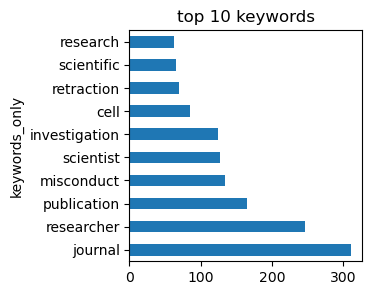

In [22]:
top10_keywords=df["keywords_only"].explode().value_counts()[:10]
top10_keywords.plot.barh(figsize=(3,3),title="top 10 keywords")

In [23]:
df["keywords_filtered"]=df["keywords_only"].apply(lambda x: [i for i in x if i not in top10_keywords.keys()])
df["keywords_filtered"].explode().value_counts()[:10]

keywords_filtered
finding      52
fossil       44
retracted    40
vaccine      40
neuron       39
science      38
gene         36
fraud        35
studie       34
protein      31
Name: count, dtype: int64

In [24]:
result.index=df.index
df=pd.concat([df, result], axis=1)

In [25]:
df["misconduct"]

Science113      [misconduct, fraud]
Science116                       []
Science119                       []
Science149                  [fraud]
Science159    [fraud, fraud, fraud]
                      ...          
Nature277                        []
Nature366                        []
Nature439                        []
Nature605                        []
Nature66                         []
Name: misconduct, Length: 2843, dtype: object

<Axes: ylabel='misconduct'>

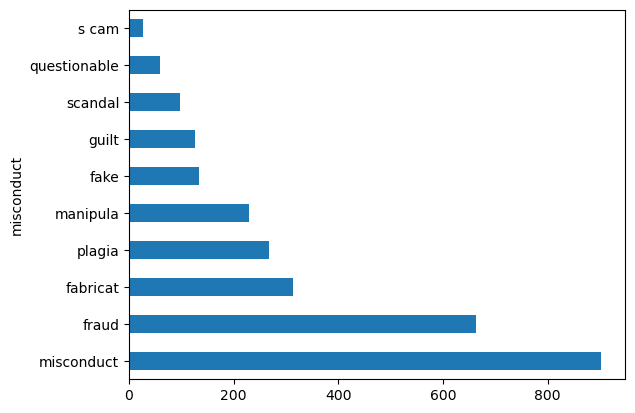

In [26]:
df.misconduct.explode().explode().dropna().value_counts()[:10].plot.barh()


In [27]:
# Define a function to compare the integer values
def compare_lists(row):
    if row["n_mistake"] > row["n_misconduct"]:
        return "mistake"
    elif row["n_mistake"] < row["n_misconduct"]:
        return "misconduct"
    else:
        return "none"

# Apply the function to each row
df["dict_topic"] = df.apply(compare_lists, axis=1)


In [28]:
df

,path,folder,journal,texts,labels,retraction_counts,has_retraction,retract_tokens,has_retraction_label,text,...,Lemmata,NoStopwords,Nouns_Verbs,misconduct,mistake,retract,n_misconduct,n_mistake,n_retract,dict_topic
Science113,Data_Science\Newly DL relevant previously mark...,Data_Science\Newly DL relevant previously mark...,Science,[The Germans Trias i Pujol University Hospital...,"[caption, text, text, section_header, text, se...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",1.0,"[retracted, retraction, retraction, retraction...","[text, text, text, section_header, text, text,...",Many other trials are still on pause.U.K. regu...,...,"[many, other, trial, be, still, on, pause, ., ...","[trials, pause, regulators, instance, asked, r...","[trial, pause, regulator, instance, ask, raft,...","[misconduct, fraud]",[],"[retract, retract, retract, retract, retract, ...",2,0,8,misconduct
Science116,Data_Science\Newly DL relevant previously mark...,Data_Science\Newly DL relevant previously mark...,Science,"[CAFFE', AURORA, CAFFE', IN DEPTH, Italy'sCovi...","[text, text, text, text, text, section_header,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,[retracted],[text],"""Whatthey'vedoneisbasicallyseenthese twobranch...",...,"["", whatthey'vedoneisbasicallyseenthese, twobr...","[twobranches, said, virus, virulent, says, But...","[twobranche, say, virus, say, butotherfactor, ...",[],[],[retract],0,0,1,none
Science119,Data_Science\Newly DL relevant previously mark...,Data_Science\Newly DL relevant previously mark...,Science,"[SCIENTIFICPUBLISHING, Elsevier to Editor: Cha...","[section_header, section_header, text, text, t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,[retracted],[text],"Charlton says he is “agnostic” ""This Article-i...",...,"[Charlton, say, he, be, "", agnostic, "", "", thi...","[Charlton, says, agnostic, Article, Press, per...","[say, article, press, withdraw, article, withd...",[],"[withdraw, withdraw, withdraw]",[retract],0,3,1,mistake
Science149,Data_Science\Newly DL relevant previously mark...,Data_Science\Newly DL relevant previously mark...,Science,"[FEATURES, THE PREPRINT DILEMMA, Biologists ar...","[text, section_header, text, section_header, t...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,[retracting],"[text, text]",By Jocelyn Kaiser Another worrisome scenario i...,...,"[by, Jocelyn, Kaiser, another, worrisome, scen...","[Jocelyn, Kaiser, worrisome, scenario, authors...","[scenario, author, post, paper, stake, claim, ...",[fraud],[],"[retrack, retract]",1,0,2,misconduct
Science159,Data_Science\Newly DL relevant previously mark...,Data_Science\Newly DL relevant previously mark...,Science,"[VACCINEMYTHS, False: Vaccination can cause au...","[section_header, section_header, text, text, t...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",1.0,"[retracted, retracted, retracted]","[text, text, text]",VACCINEMYTHS even though you sometimes think i...,...,"[vaccinemyth, even, though, you, sometimes, th...","[VACCINEMYTHS, think, work, myths, pose, probl...","[vaccinemyth, think, work, myth, pose, problem...","[fraud, fraud, fraud]","[correct, correct]","[retract, retract, retract]",3,2,3,misconduct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nature277,Data_Nature\Not relevant\Not relevant retracti...,Data_Nature\Not relevant\Not relevant retracti...,Nature,"[RETRACTION, In view of the fact that the auth...","[section_header, text, text, text, text, text,...","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1.0,"[RETRACTION, retracting, retract, RETRACTED]","[section_header, text, section_header]",RETRACTION The main innovation in Adli and col...,...,"[retraction, the, main, innovation, in, Adli, ...","[RETRACTION, main, innovation, Adli, colleague...","[retraction, innovation, colleague, workwas, m...",[],[],"[retract, retract, retract, retract]",0,0,4,none
Nature366,Data_Nature\Not relevant\Not relevant retracti...,Data

<Axes: title={'center': 'Document Level: Framing Type (dict)'}, ylabel='count'>

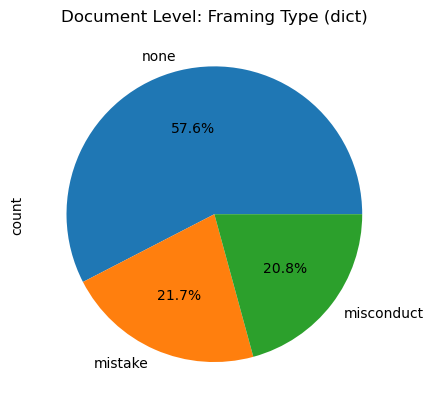

In [29]:
df.dict_topic.value_counts().plot.pie(title="Document Level: Framing Type (dict)", autopct='%1.1f%%')

In [30]:
df["NoStopwords"][0]

['trials',
 'pause',
 'regulators',
 'instance',
 'asked',
 'raft',
 'additional',
 'safeguards',
 'says',
 'Joseph',
 'Cheriyan',
 'clinical',
 'pharmacologist',
 'Cambridge',
 'University',
 'Hospital',
 'principal',
 'investigator',
 'PrEP',
 'trial',
 'health',
 'care',
 'workers',
 'study',
 'excluded',
 'patients',
 'dozens',
 'drugs',
 'Cheriyan',
 'says',
 'regulators',
 'asked',
 'changes',
 'set',
 'trial',
 'weeks',
 'despite',
 'Lancet',
 'retraction',
 'alarming',
 'headlines',
 'drug',
 'risks',
 'difficult',
 'convince',
 'people',
 'participate',
 'trial',
 'White',
 'says',
 'think',
 'trials',
 'badly',
 'damaged',
 'restart',
 'Theresults',
 'arepersuading',
 'somedoctors',
 'stop',
 'drug',
 'hydroxychloroquine',
 'despite',
 'thin',
 'evidence',
 'promise',
 'says',
 'better',
 'shifting',
 'attention',
 'drugs',
 'actually',
 'work',
 'Kremsner',
 'University',
 'Tübingen',
 'agrees',
 'awonderdrug',
 'question',
 'proceed',
 'hydroxychloroquine',
 'trials',
 'Edi

In [31]:
df.to_csv("2025-04-26 data with dict_approach.csv")